In [1]:
BATCH_SIZE = 10
EPOCHS = 30
LEARNING_RATE = 0.01
SEED = 42

In [2]:
import random
import numpy as np
import torch

In [3]:
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [ ]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = float(line[0])
            labels.append([t, 1. - t])
            sentences.append(line[1:].strip())
    return labels, sentences

In [ ]:
train_labels, train_data = read_data('../examples/datasets/discocirc_mc_train_data.txt')
dev_labels, dev_data = read_data('../examples/datasets/discocirc_mc_dev_data.txt')
test_labels, test_data = read_data('../examples/datasets/discocirc_mc_test_data.txt')

In [6]:
import os

TESTING = int(os.environ.get('TEST_NOTEBOOKS', '0'))

if TESTING:
    train_labels, train_data = train_labels[:2], train_data[:2]
    dev_labels, dev_data = dev_labels[:2], dev_data[:2]
    test_labels, test_data = test_labels[:2], test_data[:2]
    EPOCHS = 1

In [7]:
train_data[:5]

['man bakes tasty lunch . he used to be a good shef . he likes mastering new recipes',
 'woman writes efficient program . she has been a great professional . she likes mastering new approaches',
 'girl writes nice software . she is a good coder . she likes mastering novel algorithms',
 'person cooks tasty dinner . he was a modest professional . he likes trying new recipes',
 'man prepares application . he used to be a great coder . he thrives in testing novel algorithms']

In [8]:
train_labels[:5]

[[1.0, 0.0], [0.0, 1.0], [0.0, 1.0], [1.0, 0.0], [0.0, 1.0]]

In [ ]:
from lambeq.experimental.discocirc import DisCoCircReader

reader = DisCoCircReader()

raw_train_diags = [reader.text2circuit(t, sandwich=True) for t in train_data]
raw_dev_diags = [reader.text2circuit(t, sandwich=True) for t in dev_data]
raw_test_diags = [reader.text2circuit(t, sandwich=True) for t in test_data]

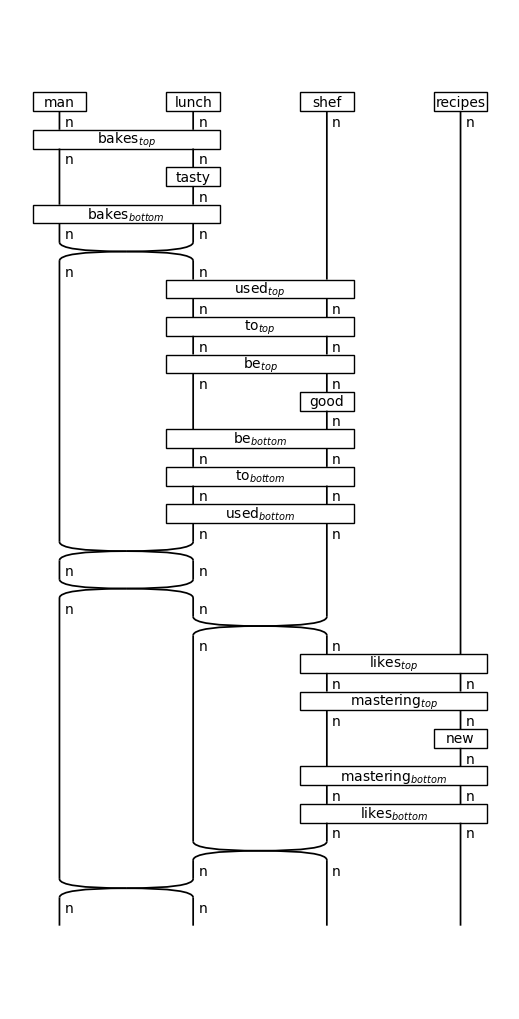

In [12]:
raw_train_diags[0].draw(figsize=(5,10))

In [ ]:
from lambeq import AtomicType
from lambeq.backend.grammar import Box, Ty

# Declare the types we will use
N = AtomicType.NOUN
T = Ty('t')     # 't' for 'text'

# Add fan-in box as last layer for each diagram
def add_fan_in_box(diag):
    fan_in_box = Box(name='fan in',
                     dom=diag.cod,
                     cod=T)
    diag >>= fan_in_box
    return diag

train_diags = [add_fan_in_box(d) for d in raw_train_diags]
dev_diags = [add_fan_in_box(d) for d in raw_dev_diags]
test_diags = [add_fan_in_box(d) for d in raw_test_diags]

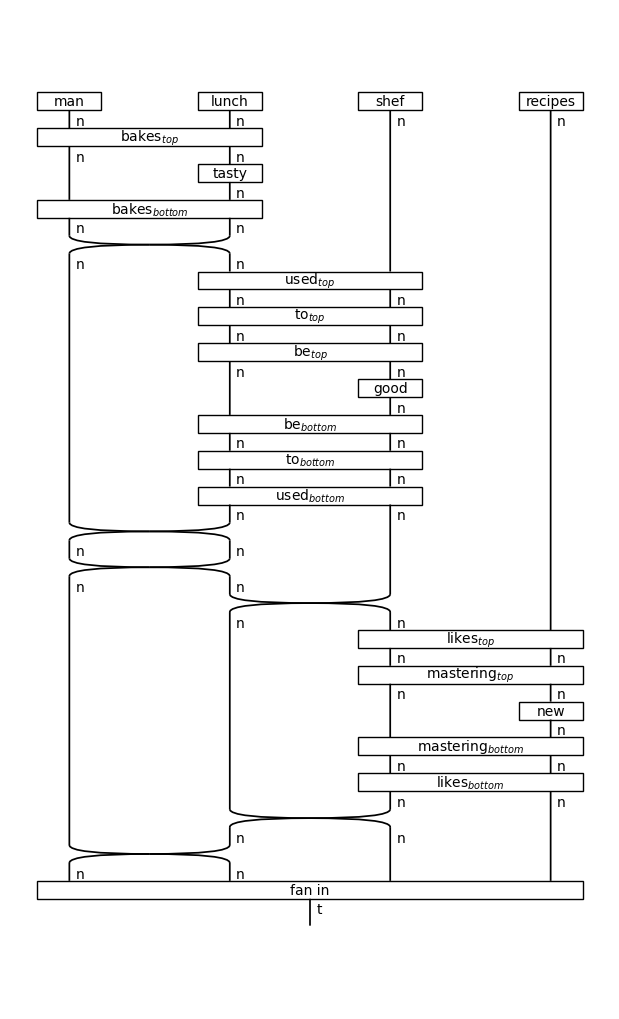

In [15]:
train_diags[0].draw(figsize=(6, 10))

In [ ]:
from lambeq import Sim4Ansatz

ansatz = Sim4Ansatz({N: 1, T: 1}, n_layers=3)

train_circs = [ansatz(diag) for diag in train_diags]
dev_circs = [ansatz(diag) for diag in dev_diags]
test_circs = [ansatz(diag) for diag in test_diags]

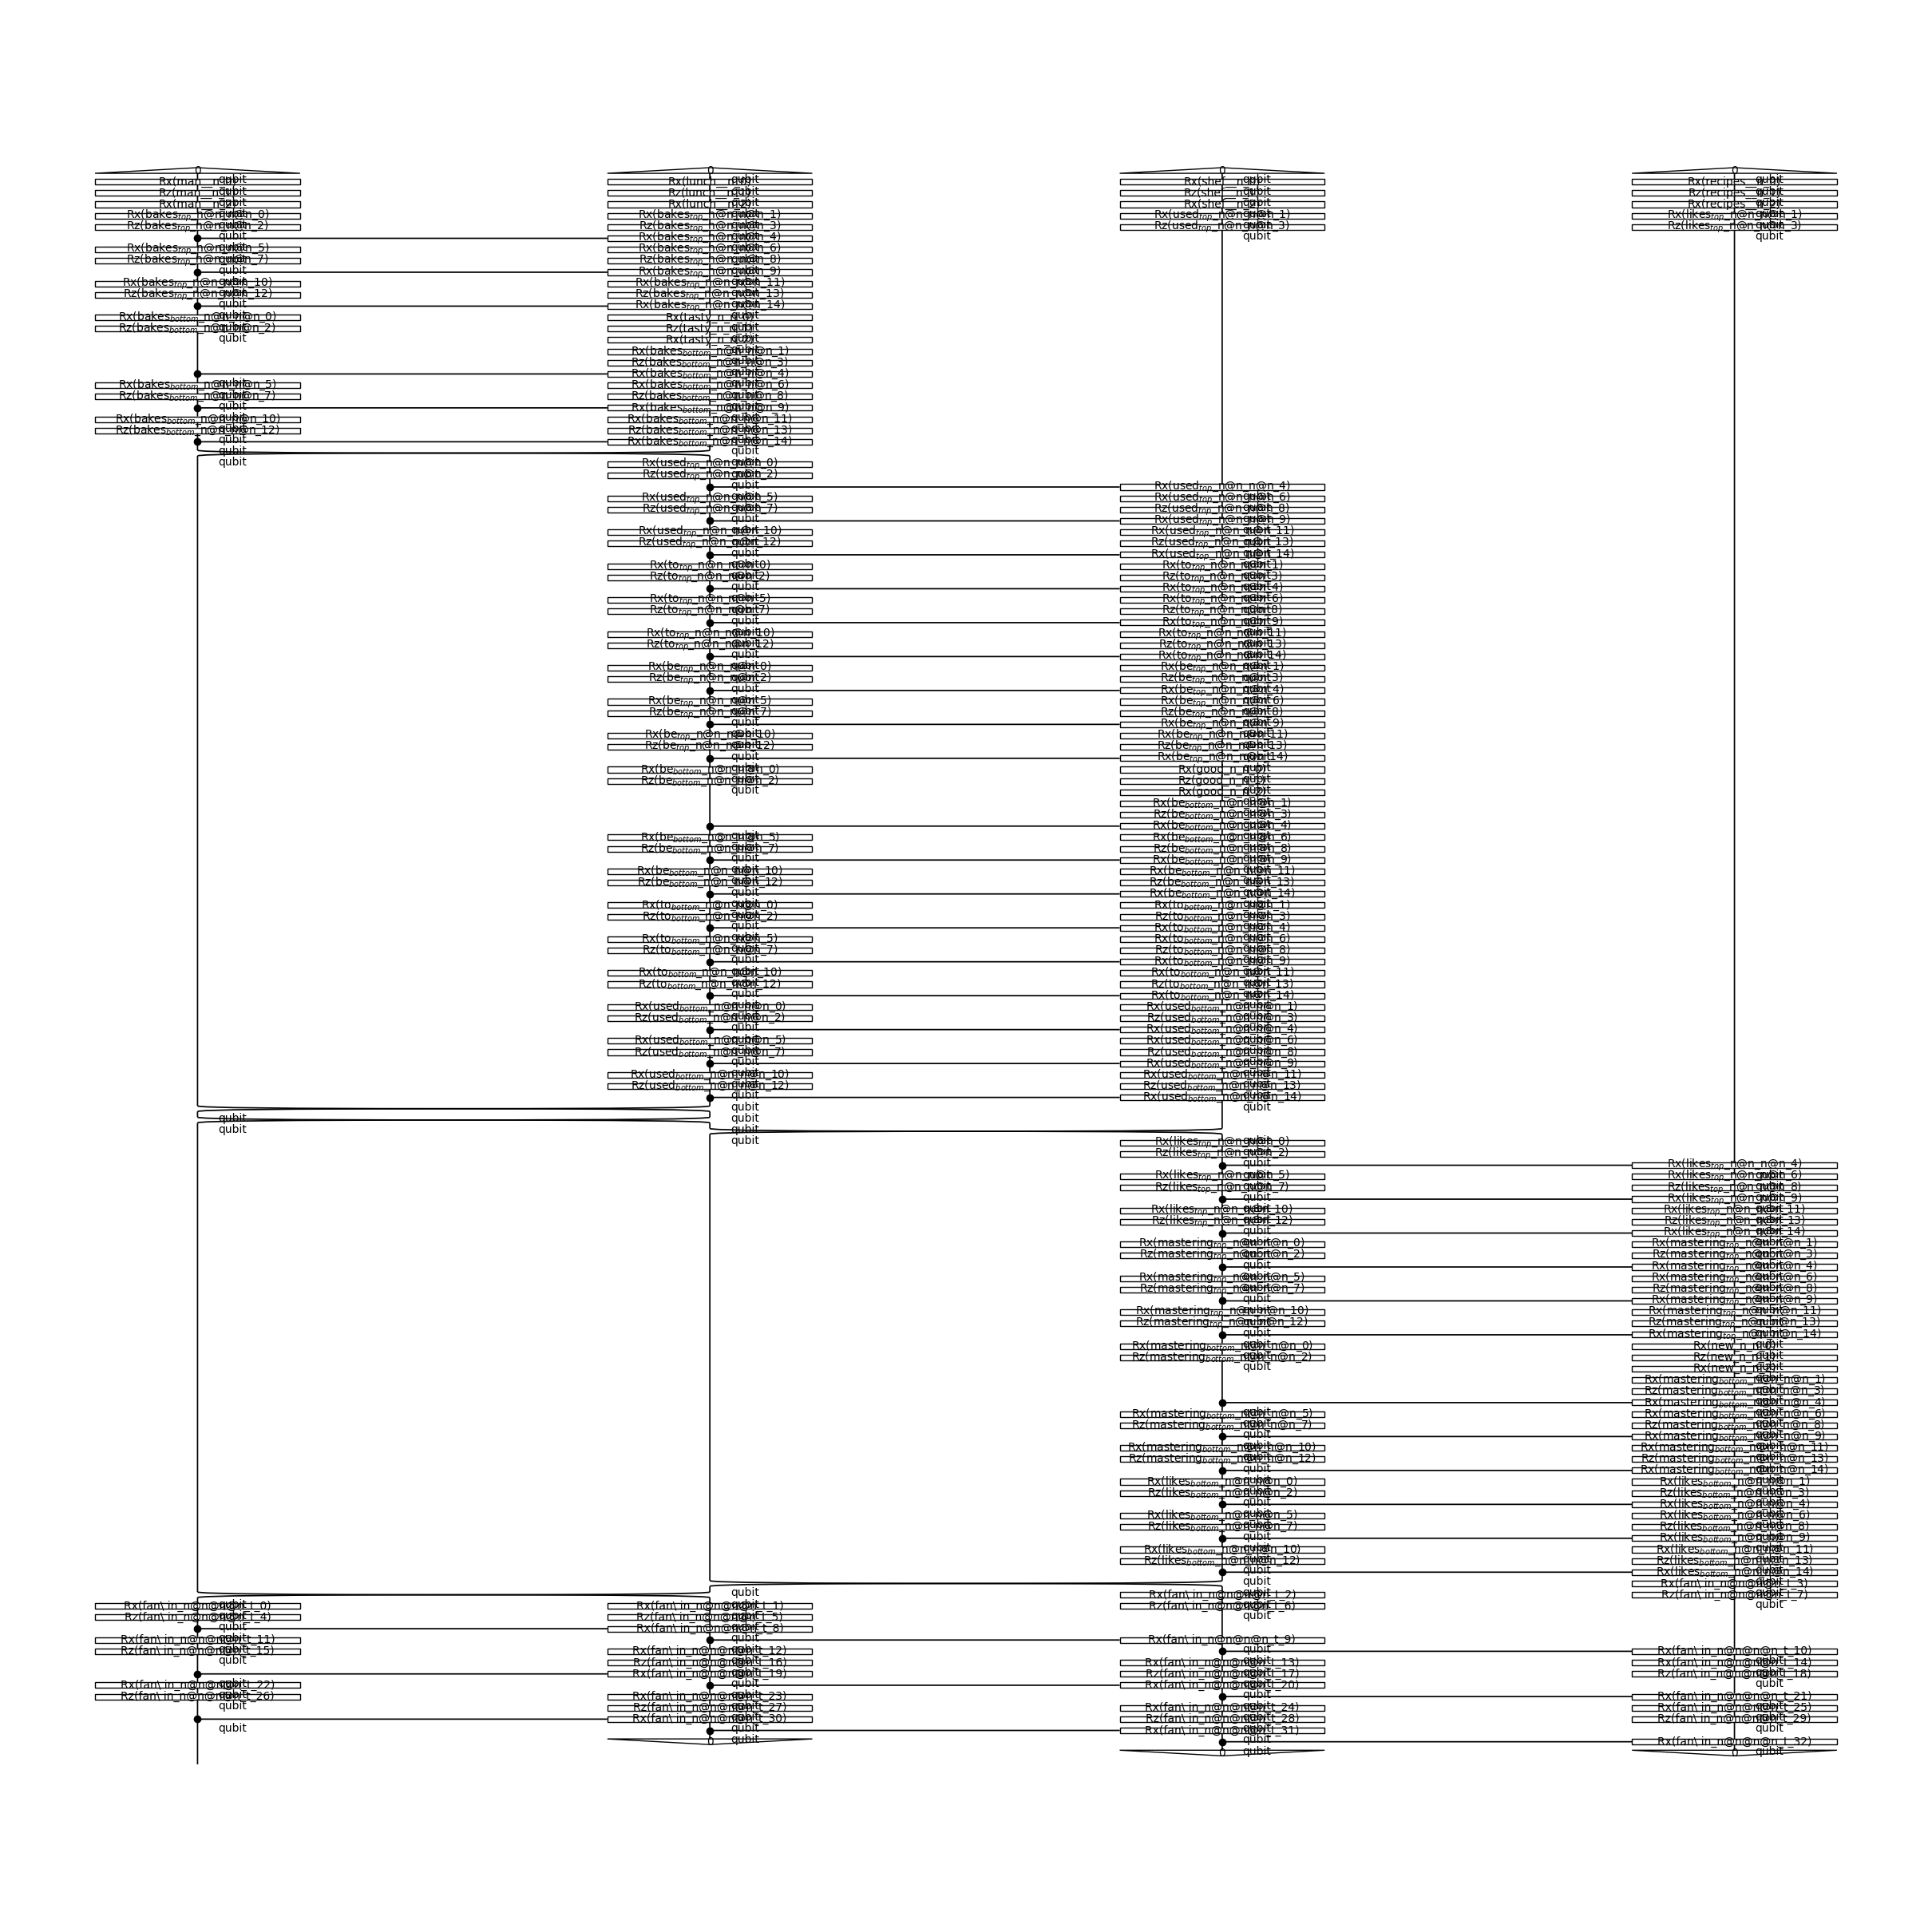

In [18]:
train_circs[0].draw(figsize=(24, 24))

In [ ]:
from lambeq import PennyLaneModel

all_circs = train_circs + dev_circs + test_circs

# if no backend_config is provided, the default is used
backend_config = {'backend': 'default.qubit'}  # this is the default PennyLane simulator
model = PennyLaneModel.from_diagrams(all_circs,
                                     probabilities=True,
                                     normalize=True,
                                     backend_config=backend_config)
model.initialise_weights()

In [ ]:
from lambeq import Dataset

train_dataset = Dataset(train_circs,
                        train_labels,
                        batch_size=BATCH_SIZE)

dev_dataset = Dataset(dev_circs,
                      dev_labels,
                      shuffle=False)

In [21]:
def acc(y_hat, y):
    return (torch.argmax(y_hat, dim=1) ==
            torch.argmax(y, dim=1)).sum().item()/len(y)


def loss(y_hat, y):
    return torch.nn.functional.binary_cross_entropy(
        y_hat, torch.Tensor(y)
    )

In [ ]:
from lambeq import PytorchTrainer

trainer = PytorchTrainer(
    model=model,
    loss_function=loss,
    optimizer=torch.optim.Adam,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS,
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    use_tensorboard=False,
    verbose='text',
    seed=SEED)

In [23]:
trainer.fit(train_dataset, dev_dataset)

Epoch 1:   train/loss: 0.9695   valid/loss: 1.0455   train/time: 4m15s   valid/time: 1m24s   train/acc: 0.5000   valid/acc: 0.5000
Epoch 2:   train/loss: 1.2423   valid/loss: 0.8468   train/time: 4m18s   valid/time: 1m26s   train/acc: 0.5167   valid/acc: 0.4500
Epoch 3:   train/loss: 1.4184   valid/loss: 0.8690   train/time: 4m19s   valid/time: 1m27s   train/acc: 0.5333   valid/acc: 0.5667
Epoch 4:   train/loss: 0.4773   valid/loss: 1.0767   train/time: 4m20s   valid/time: 1m26s   train/acc: 0.5889   valid/acc: 0.4333
Epoch 5:   train/loss: 0.9689   valid/loss: 0.8239   train/time: 4m23s   valid/time: 1m26s   train/acc: 0.5333   valid/acc: 0.6000
Epoch 6:   train/loss: 0.9354   valid/loss: 0.8176   train/time: 4m25s   valid/time: 1m29s   train/acc: 0.5333   valid/acc: 0.5500
Epoch 7:   train/loss: 1.0967   valid/loss: 0.9583   train/time: 4m27s   valid/time: 1m28s   train/acc: 0.5222   valid/acc: 0.4500
Epoch 8:   train/loss: 0.5902   valid/loss: 0.8774   train/time: 4m28s   valid/time

Final test accuracy: 0.9666666666666667


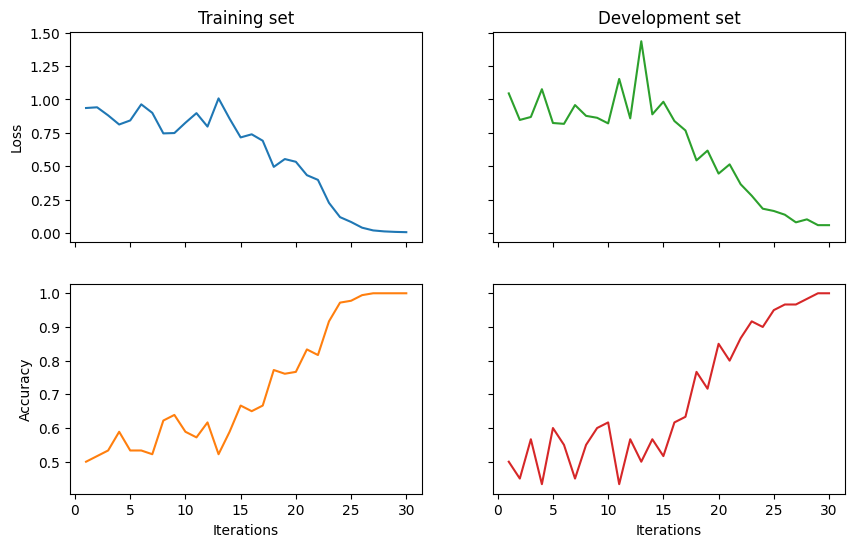

In [24]:
import matplotlib.pyplot as plt


fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2,
                                                     sharex=True,
                                                     sharey='row',
                                                     figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# print test accuracy
pred = model(test_circs)
labels = torch.tensor(test_labels)

print('Final test accuracy: {}'.format(acc(pred, labels)))